<a href="https://colab.research.google.com/github/Jhaveth/Simulacion-ll/blob/main/Proyecto_de_Simulacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Repostar gasolinera
Carro 0 Llegando a la gasolinera a las 87.0
Carro 0 termino de recargar gasolina en 18.5 segundos.
Carro 1 Llegando a la gasolinera a las 129.0
Carro 1 termino de recargar gasolina en 19.0 segundos.
Carro 2 Llegando a la gasolinera a las 284.0
Carro 2 termino de recargar gasolina en 21.0 segundos.
Carro 3 Llegando a la gasolinera a las 385.0
Carro 3 termino de recargar gasolina en 13.5 segundos.
Carro 4 Llegando a la gasolinera a las 459.0
Llamado de camion cisterna a las 460
Carro 4 termino de recargar gasolina en 22.0 segundos.
Carro 5 Llegando a la gasolinera a las 705.0
Carro 6 Llegando a la gasolinera a las 750.0
El camion cisterna llego a la hora:  760
El camion cisterna reabastercio: 188.0 litros.
Carro 6 termino de recargar gasolina en 29.0 segundos.
Carro 5 termino de recargar gasolina en 76.5 segundos.
Carro 7 Llegando a la gasolinera a las 891.0
Carro 7 termino de recargar gasolina en 13.0 segundos.
Carro 8 Llegando a la gasolinera a las 1179.0
Carro 8 te

Text(0, 0.5, 'Litros de gasolina')

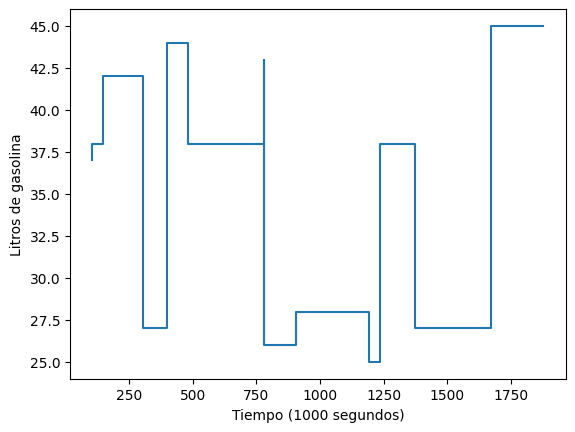

In [ ]:
"""
Ejemplo de repostaje de Gasolina

Una gasolinera tiene un número limitado de surtidores de gasolina que
comparten un depósito de combustible común.
Los autos llegan aleatoriamente a la estación de servicio, solicita una
de las bombas de combustible y comienza a repostar desde ese depósito.

Un proceso de control de gasolineras observa el nivel de combustible de
la gasolinera y llama a un camión cisterna para repostar si el nivel de
la estación baja por debajo de un umbral.

"""
!pip install simpy
import itertools
import random
import matplotlib.pyplot as plt
import simpy
#Se define la lista de los tiempos observados y litros vendidos
tiempos = []
litros_vendidos = []

RANDOM_SEED = 42
GAS_STATION_SIZE = 200     # litros de la estacion de gasolina
THRESHOLD = 10             # Faltante para llamar al camion sisterna (in %)
FUEL_TANK_SIZE = 50        # litros
FUEL_TANK_LEVEL = [5, 25]  # niveles minimos/maximos de los tanques de
                           # combustible
REFUELING_SPEED = 2        # litros por segundo
TANK_TRUCK_TIME = 300      # Segundos que tarda en llegar un camion cisterna
T_INTER = [30, 300]        # Generar un automovil cada [min/max] segundos
SIM_TIME = 2000            # Tiempo de simulacion en segundos


def car(name, env, gas_station, fuel_pump):
    """
    "Un coche llega a la gasolinera para repostar.

Solicita una de las bombas de combustible de la estación de servicio e intenta
obtener la cantidad deseada de combustible. Si el depósito de la estación se
agota, el automóvil debe esperar a que llegue el camión cisterna.

    """
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    print('%s Llegando a la gasolinera a las %.1f' % (name, env.now))
    with gas_station.request() as req:
        start = env.now
        # Solicitar uno de los surtidores de gasolina.
        yield req

        # Obtencion de la cantidad requerida de combustible
        liters_required = FUEL_TANK_SIZE - fuel_tank_level
        yield fuel_pump.get(liters_required)

        # El proceso "actual simulado" lleva un tiempo indeterminado
        yield env.timeout(liters_required / REFUELING_SPEED)

        print('%s termino de recargar gasolina en %.1f segundos.' % (name,env.now - start))
        tiempos.append(env.now)
        litros_vendidos.append(liters_required)


def gas_station_control(env, fuel_pump):
    """Revision periodica del nivel con el que cuenta la gasolinera de gasolina
     si este cae debajo de un nivel establecido
      llamar a una bomba para el reabastecimiento"""
      #Se establece un minimo del 10% de capacidad en la gasolinera para llamar al camion cisterna
    while True:
        if fuel_pump.level / fuel_pump.capacity * 100 < THRESHOLD:
            # necesitamos llamar a la bomba para reabastecimiento ahora!
            print('Llamado de camion cisterna a las %d' % env.now)
            # Espere a que llegue el camión cisterna y reposte la estación
            yield env.process(tank_truck(env, fuel_pump))

        yield env.timeout(10)  # Se verifica lo anterior cada 10 segundos


def tank_truck(env, fuel_pump):
    """El camion cisterna llega a la gasolinera."""
    yield env.timeout(TANK_TRUCK_TIME)
    print('El camion cisterna llego a la hora:  %d' % env.now)
    ammount = fuel_pump.capacity - fuel_pump.level
    print('El camion cisterna reabastercio: %.1f litros.' % ammount)
    yield fuel_pump.put(ammount)


def car_generator(env, gas_station, fuel_pump):
    """Se generan nuevos autos que llegaron a la gasolineria"""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        env.process(car('Carro %d' % i, env, gas_station, fuel_pump))

#Se definen las listas de tiempos observados y gasolina vendida





# Configurar e iniciar la simulacion
print('Repostar gasolinera')
random.seed(RANDOM_SEED)

# Crear entornos e iniciar procesos
env = simpy.Environment()
gas_station = simpy.Resource(env, 2)
fuel_pump = simpy.Container(env, GAS_STATION_SIZE, init=GAS_STATION_SIZE)
env.process(gas_station_control(env, fuel_pump))
env.process(car_generator(env, gas_station, fuel_pump))

# Ejecutar
env.run(until=SIM_TIME)

#Modulo para graficar
plt.figure()
#Comandos para dibujar nuestras gráficas con titulos
plt.step(tiempos, litros_vendidos )
plt.xlabel('Tiempo (1000 segundos)')
plt.ylabel('Litros de gasolina')

#plt.plot(litros_vendidos, tiempos)
#plt.xlabel('Litros vendidos')
#plt.ylabel('Tiempo (segundos)')
#plt.title('Litros de gasolina vendida con respecto al tiempo')
#plt.show()